# Jewelry Image Classification

This notebook demonstrates how to build and train an image classification model for jewelry items.

## Overview
- **Task**: Multi-class classification of jewelry images
- **Approach**: Transfer learning with pre-trained models (EfficientNet, ResNet, MobileNet)
- **Categories**: Rings, Necklaces, Earrings, Bracelets, Pendants, etc.

## 1. Setup and Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("✓ All imports successful!")

PyTorch version: 2.6.0a0+df5bbc09d1.nv24.11
Torchvision version: 0.20.0a0
CUDA Available: True
GPU: NVIDIA GB10
✓ All imports successful!


## 2. Data Exploration

In [3]:
# Set up data paths
DATA_DIR = Path("/project/data/raw_jewelry")
MODEL_DIR = Path("/project/models")
MODEL_DIR.mkdir(exist_ok=True)

# Explore the dataset structure
categories = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
print(f"Number of categories: {len(categories)}")
print(f"Categories: {categories}\n")

# Count images in each category
category_counts = {}
for category in categories:
    category_path = DATA_DIR / category
    image_files = list(category_path.glob("*.jpg")) + list(category_path.glob("*.png"))
    category_counts[category] = len(image_files)
    print(f"{category}: {len(image_files)} images")

print(f"\nTotal images: {sum(category_counts.values())}")

Number of categories: 8
Categories: ['anklets', 'bracelets', 'brooches', 'earrings', 'necklaces', 'pendants', 'rings', 'watches']

anklets: 50 images
bracelets: 50 images
brooches: 50 images
earrings: 50 images
necklaces: 50 images
pendants: 50 images
rings: 50 images
watches: 50 images

Total images: 400


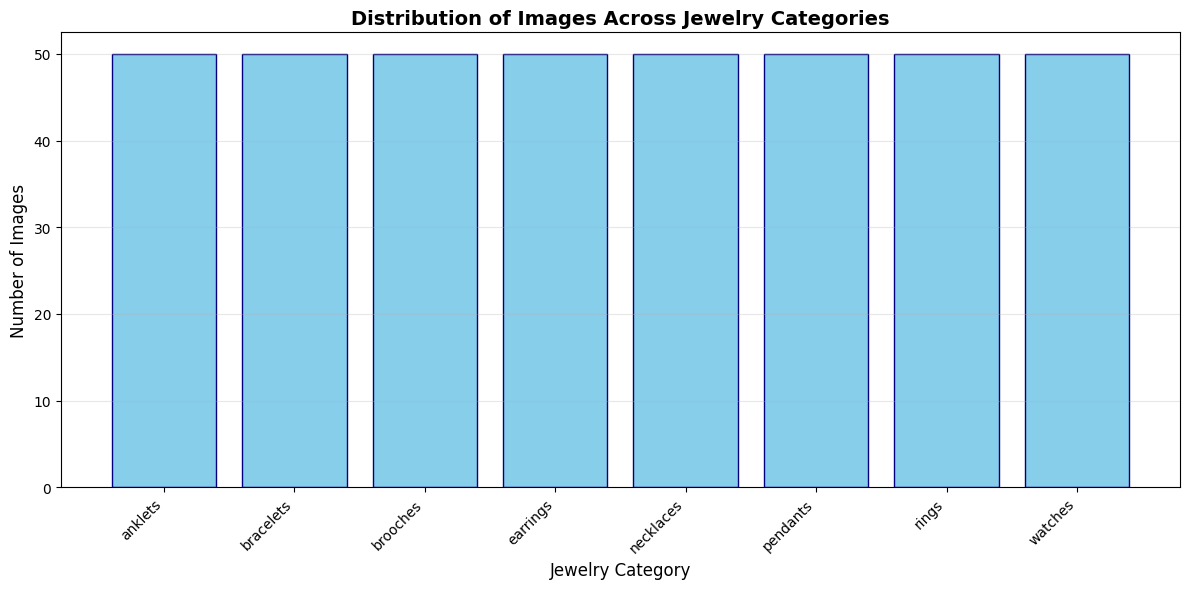

In [4]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue', edgecolor='navy')
plt.xlabel('Jewelry Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Images Across Jewelry Categories', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

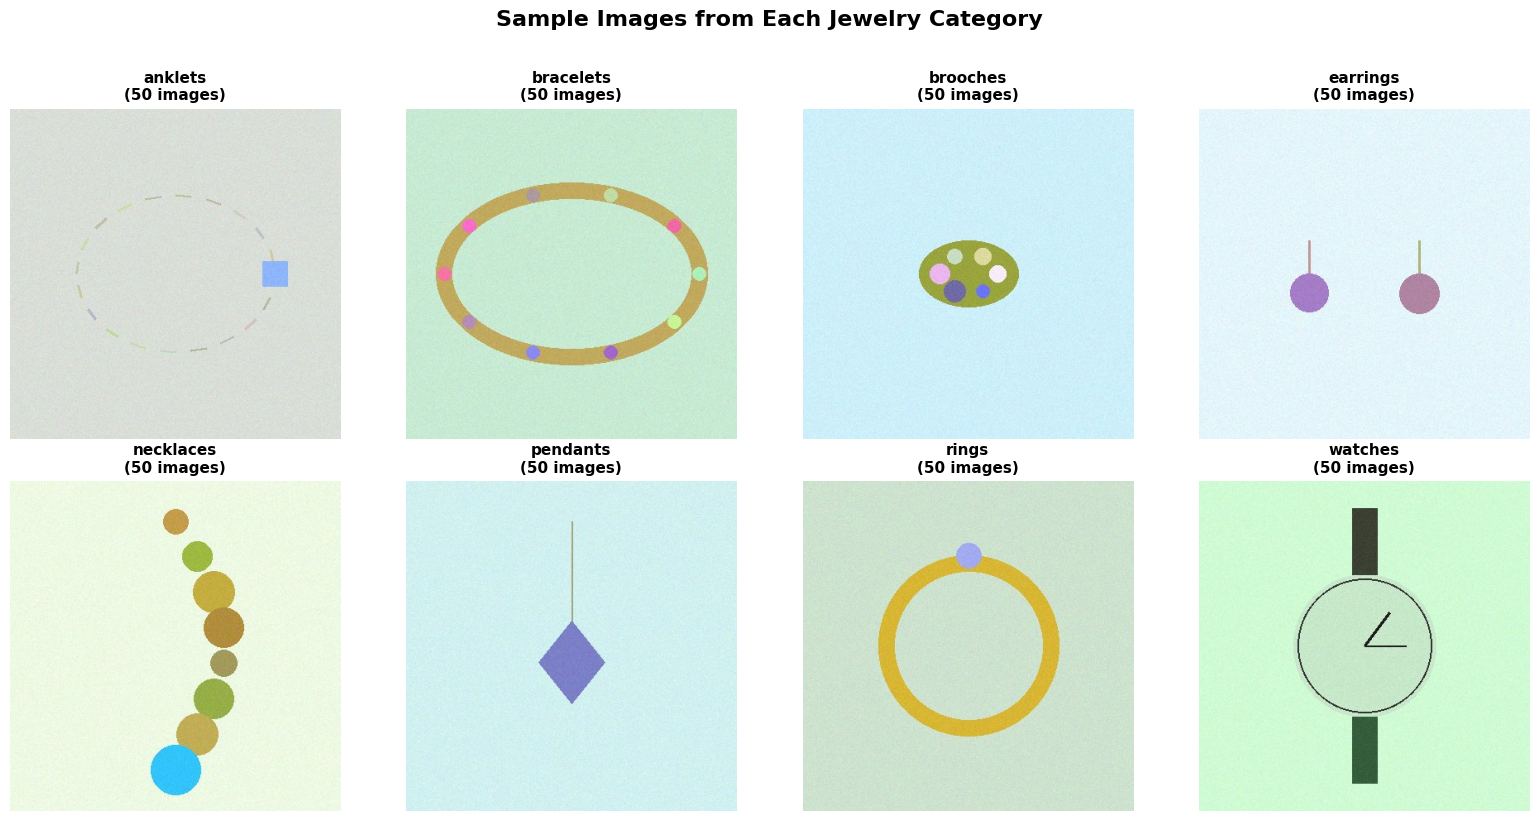

In [5]:
# Display sample images from each category
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, category in enumerate(categories):
    category_path = DATA_DIR / category
    image_files = list(category_path.glob("*.jpg")) + list(category_path.glob("*.png"))
    
    if image_files:
        # Load and display a random image
        sample_img_path = np.random.choice(image_files)
        img = plt.imread(sample_img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"{category}\n({len(image_files)} images)", fontsize=11, fontweight='bold')
        axes[idx].axis('off')

plt.suptitle('Sample Images from Each Jewelry Category', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3. Data Preparation and Augmentation

In [6]:
# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(f"Device: {DEVICE}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {EPOCHS}")

Device: cpu
Image size: 224x224
Batch size: 32
Learning rate: 0.001
Number of epochs: 20


In [7]:
# Custom Dataset class
class JewelryDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Collect all image paths and labels
all_image_paths = []
all_labels = []
class_to_idx = {cat: idx for idx, cat in enumerate(categories)}
idx_to_class = {idx: cat for cat, idx in class_to_idx.items()}

for category in categories:
    category_path = DATA_DIR / category
    image_files = list(category_path.glob("*.jpg")) + list(category_path.glob("*.png"))
    all_image_paths.extend(image_files)
    all_labels.extend([class_to_idx[category]] * len(image_files))

# Split into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Create datasets
train_dataset = JewelryDataset(train_paths, train_labels, transform=train_transform)
val_dataset = JewelryDataset(val_paths, val_labels, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = categories
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"\nTraining samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Number of classes: 8
Class names: ['anklets', 'bracelets', 'brooches', 'earrings', 'necklaces', 'pendants', 'rings', 'watches']

Training samples: 320
Validation samples: 80
Training batches: 10
Validation batches: 3


## 4. Model Building with Transfer Learning

In [8]:
# Build model using MobileNetV2 as base
def create_model(num_classes):
    # Load pre-trained MobileNetV2
    model = models.mobilenet_v2(pretrained=True)
    
    # Freeze the base model
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the classifier
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    
    return model

model = create_model(num_classes)
model = model.to(DEVICE)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

print("Model created successfully!")
print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/workbench/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 35.1MB/s]

Model created successfully!

Model architecture:
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1)

## 5. Training the Model

In [9]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': running_loss/len(pbar), 'acc': 100.*correct/total})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': running_loss/len(pbar), 'acc': 100.*correct/total})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Train the model
print("Starting training...\n")
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("-" * 50)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, DEVICE)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_DIR / 'best_model.pth')
        print(f"✓ Saved best model with validation accuracy: {val_acc:.2f}%")
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    print()

print("\n✓ Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it, loss=1.14, acc=55]   


Train Loss: 1.6039 | Train Acc: 45.62%
Val Loss: 1.1432 | Val Acc: 55.00%
✓ Saved best model with validation accuracy: 55.00%

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:07<00:00,  2.51s/it, loss=0.304, acc=98.8]


Train Loss: 0.7349 | Train Acc: 82.19%
Val Loss: 0.3037 | Val Acc: 98.75%
✓ Saved best model with validation accuracy: 98.75%

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.089, acc=100] 


Train Loss: 0.3420 | Train Acc: 95.00%
Val Loss: 0.0890 | Val Acc: 100.00%
✓ Saved best model with validation accuracy: 100.00%

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it, loss=0.0815, acc=100]


Train Loss: 0.2166 | Train Acc: 94.69%
Val Loss: 0.0815 | Val Acc: 100.00%

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it, loss=0.0534, acc=98.8]


Train Loss: 0.1424 | Train Acc: 97.50%
Val Loss: 0.0534 | Val Acc: 98.75%

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it, loss=0.0654, acc=100]


Train Loss: 0.1288 | Train Acc: 96.25%
Val Loss: 0.0654 | Val Acc: 100.00%

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it, loss=0.0218, acc=100] 


Train Loss: 0.1368 | Train Acc: 96.25%
Val Loss: 0.0218 | Val Acc: 100.00%

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it, loss=0.0134, acc=100]


Train Loss: 0.0772 | Train Acc: 98.44%
Val Loss: 0.0134 | Val Acc: 100.00%

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it, loss=0.0181, acc=100] 


Train Loss: 0.0679 | Train Acc: 99.06%
Val Loss: 0.0181 | Val Acc: 100.00%

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it, loss=0.0108, acc=100] 


Train Loss: 0.0561 | Train Acc: 98.12%
Val Loss: 0.0108 | Val Acc: 100.00%

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.02s/it, loss=0.00947, acc=100]


Train Loss: 0.0450 | Train Acc: 99.06%
Val Loss: 0.0095 | Val Acc: 100.00%

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.22s/it, loss=0.0143, acc=100] 


Train Loss: 0.0532 | Train Acc: 99.06%
Val Loss: 0.0143 | Val Acc: 100.00%

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:07<00:00,  2.50s/it, loss=0.00627, acc=100]


Train Loss: 0.0361 | Train Acc: 100.00%
Val Loss: 0.0063 | Val Acc: 100.00%

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it, loss=0.00611, acc=100]


Train Loss: 0.0403 | Train Acc: 98.75%
Val Loss: 0.0061 | Val Acc: 100.00%

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.14s/it, loss=0.00614, acc=100]


Train Loss: 0.0343 | Train Acc: 99.38%
Val Loss: 0.0061 | Val Acc: 100.00%

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.25s/it, loss=0.00706, acc=100]


Train Loss: 0.0555 | Train Acc: 98.44%
Val Loss: 0.0071 | Val Acc: 100.00%

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it, loss=0.00366, acc=100]


Train Loss: 0.0425 | Train Acc: 98.75%
Val Loss: 0.0037 | Val Acc: 100.00%

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.97s/it, loss=0.00407, acc=100]


Train Loss: 0.0286 | Train Acc: 99.06%
Val Loss: 0.0041 | Val Acc: 100.00%

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it, loss=0.00327, acc=100]


Train Loss: 0.0301 | Train Acc: 100.00%
Val Loss: 0.0033 | Val Acc: 100.00%

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:07<00:00,  2.41s/it, loss=0.00379, acc=100]

Train Loss: 0.0197 | Train Acc: 100.00%
Val Loss: 0.0038 | Val Acc: 100.00%


✓ Training completed!
Best validation accuracy: 100.00%


## 6. Visualize Training Results

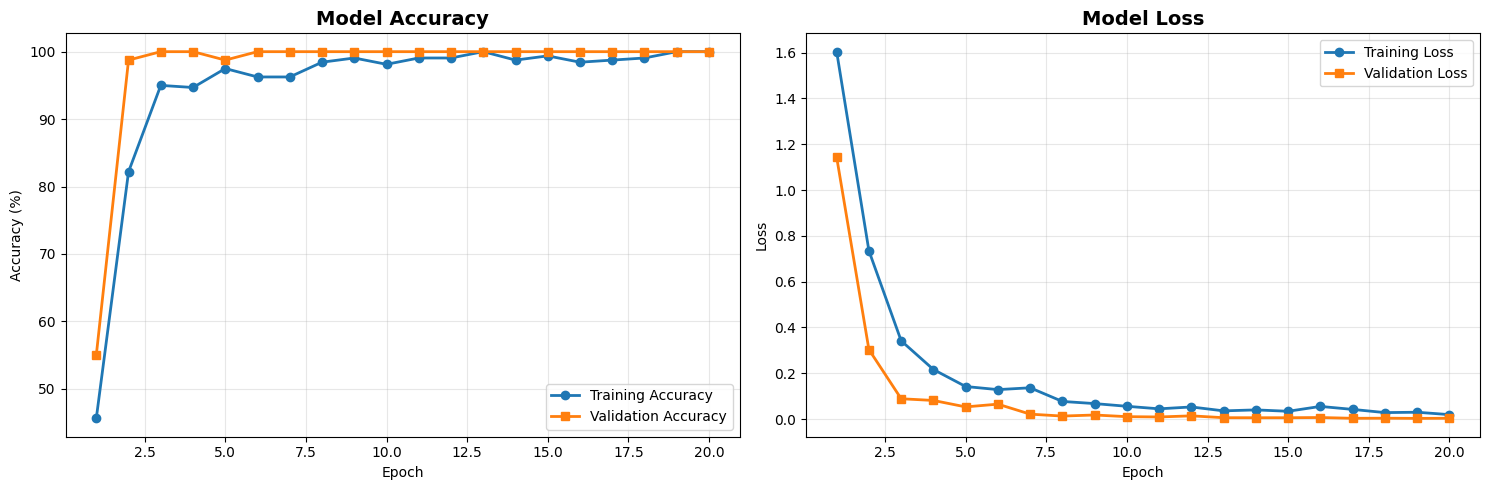


Final Training Accuracy: 100.00%
Final Validation Accuracy: 100.00%
Final Training Loss: 0.0197
Final Validation Loss: 0.0038

Best Validation Accuracy: 100.00%


In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Accuracy
axes[0].plot(epochs_range, history['train_acc'], label='Training Accuracy', linewidth=2, marker='o')
axes[0].plot(epochs_range, history['val_acc'], label='Validation Accuracy', linewidth=2, marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(epochs_range, history['train_loss'], label='Training Loss', linewidth=2, marker='o')
axes[1].plot(epochs_range, history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"\nBest Validation Accuracy: {max(history['val_acc']):.2f}%")

## 7. Model Evaluation

In [11]:
# Get predictions on validation set
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Evaluating'):
        images = images.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Classification report
print("\nClassification Report:")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Overall accuracy
overall_acc = accuracy_score(y_true, y_pred)
print(f"\nOverall Validation Accuracy: {overall_acc:.4f} ({overall_acc*100:.2f}%)")

Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Classification Report:
              precision    recall  f1-score   support

     anklets     1.0000    1.0000    1.0000        10
   bracelets     1.0000    1.0000    1.0000        10
    brooches     1.0000    1.0000    1.0000        10
    earrings     1.0000    1.0000    1.0000        10
   necklaces     1.0000    1.0000    1.0000        10
    pendants     1.0000    1.0000    1.0000        10
       rings     1.0000    1.0000    1.0000        10
     watches     1.0000    1.0000    1.0000        10

    accuracy                         1.0000        80
   macro avg     1.0000    1.0000    1.0000        80
weighted avg     1.0000    1.0000    1.0000        80


Overall Validation Accuracy: 1.0000 (100.00%)


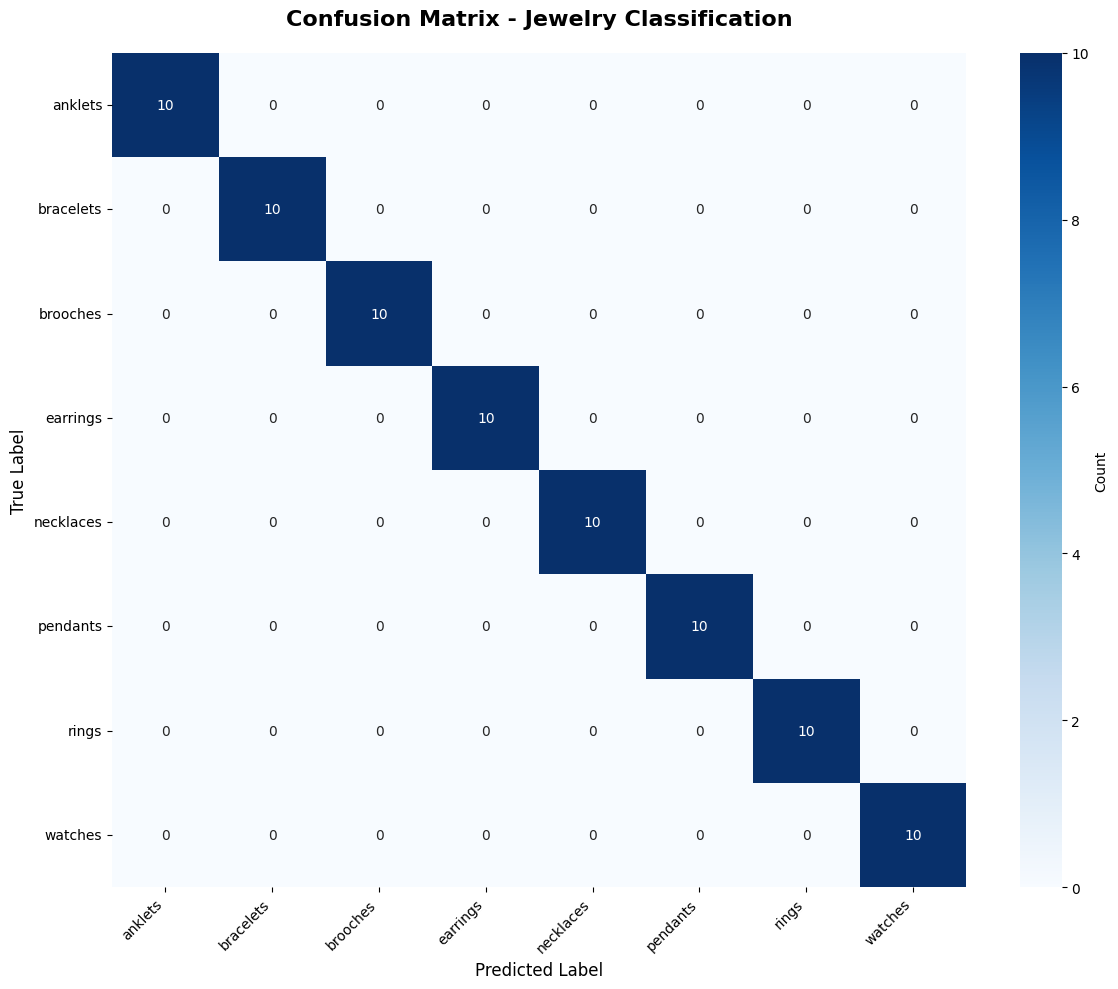

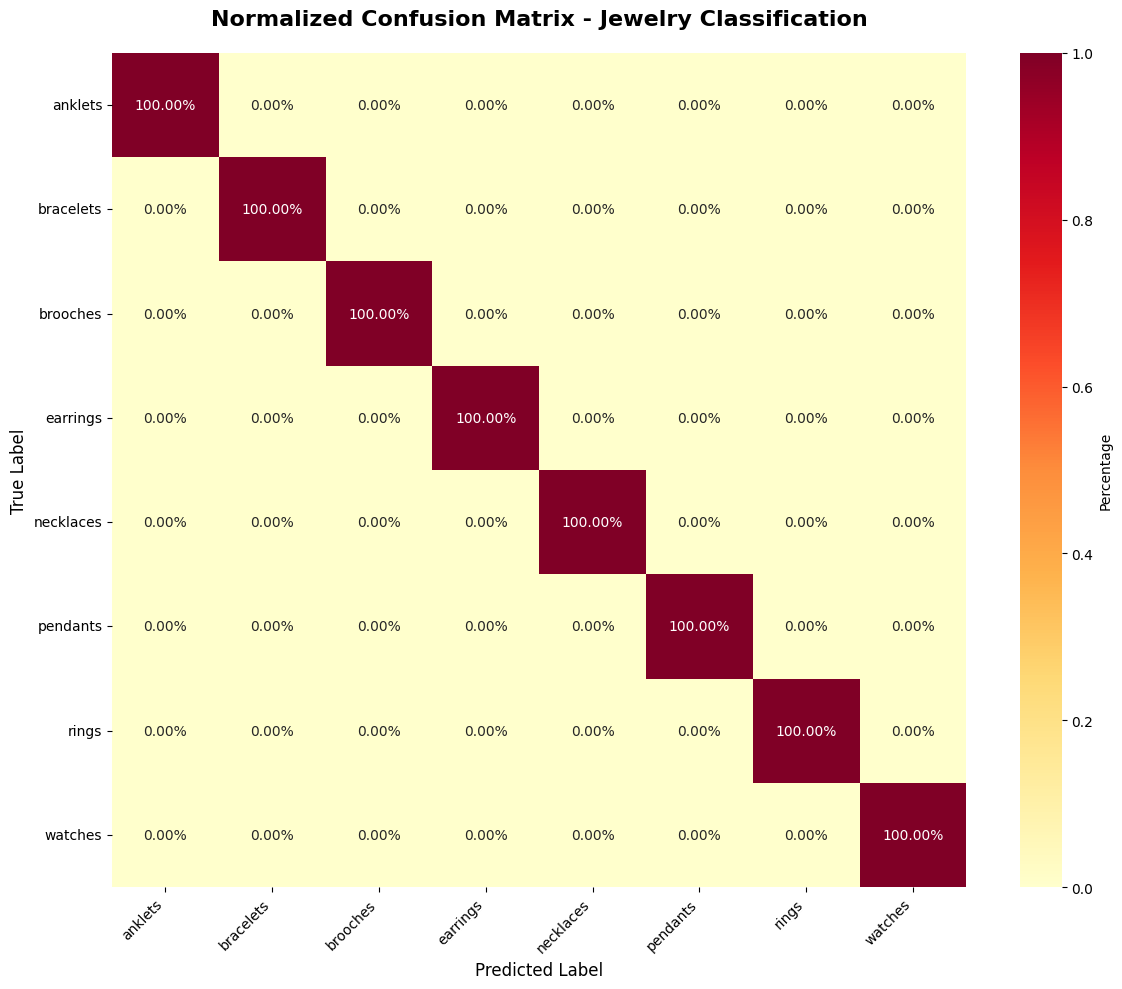

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Jewelry Classification', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix - Jewelry Classification', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 8. Prediction Examples

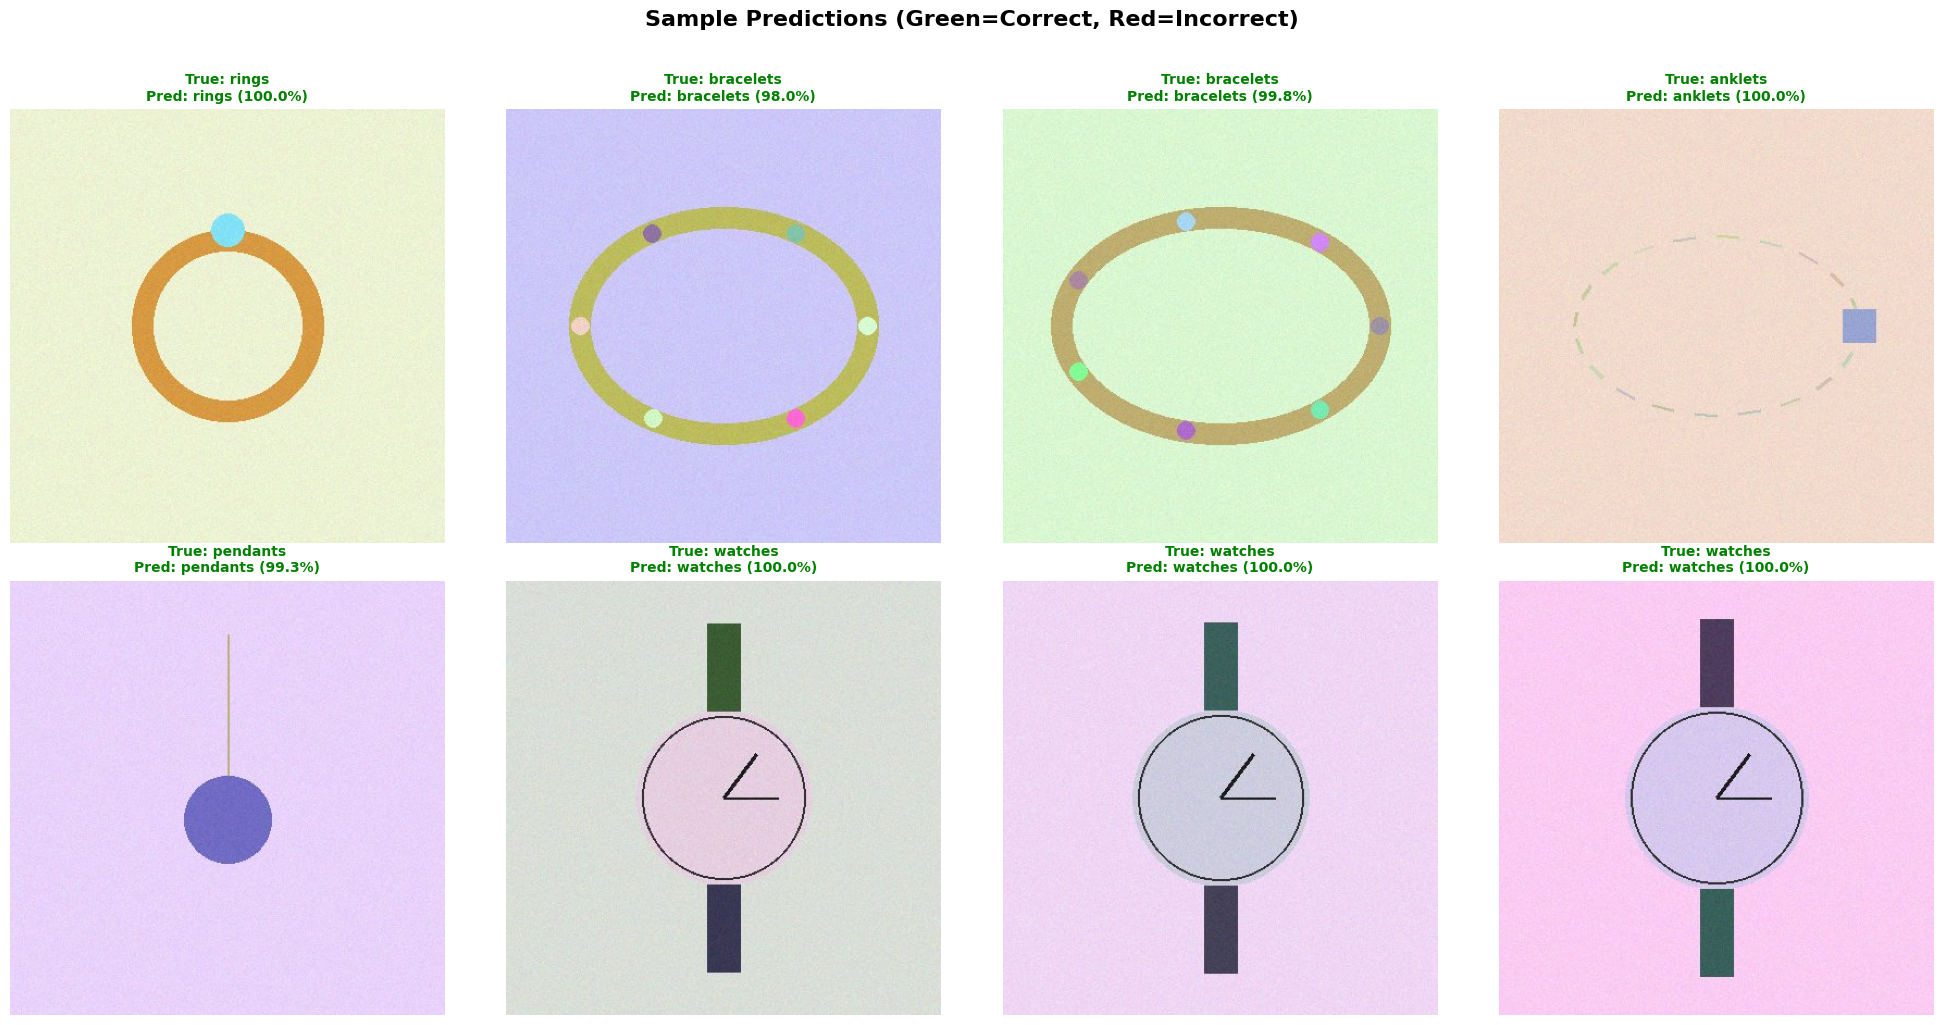

In [13]:
# Function to predict and visualize
def predict_image(img_path, model, device, transform):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)[0]
        top_3_idx = torch.topk(probs, 3).indices.cpu().numpy()
        top_3_probs = torch.topk(probs, 3).values.cpu().numpy()
    
    return img, probs.cpu().numpy(), top_3_idx

# Display predictions for random samples
num_samples = 8
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx in range(num_samples):
    # Get a random image from validation set
    random_idx = np.random.randint(0, len(val_dataset))
    img_path = val_paths[random_idx]
    true_label = val_labels[random_idx]
    true_class = idx_to_class[true_label]
    
    # Make prediction
    img, probs, top_3_idx = predict_image(img_path, model, DEVICE, val_transform)
    pred_label = top_3_idx[0]
    pred_class = idx_to_class[pred_label]
    confidence = probs[pred_label] * 100
    
    # Display
    axes[idx].imshow(img)
    color = 'green' if pred_class == true_class else 'red'
    axes[idx].set_title(
        f"True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)",
        fontsize=10, fontweight='bold', color=color
    )
    axes[idx].axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

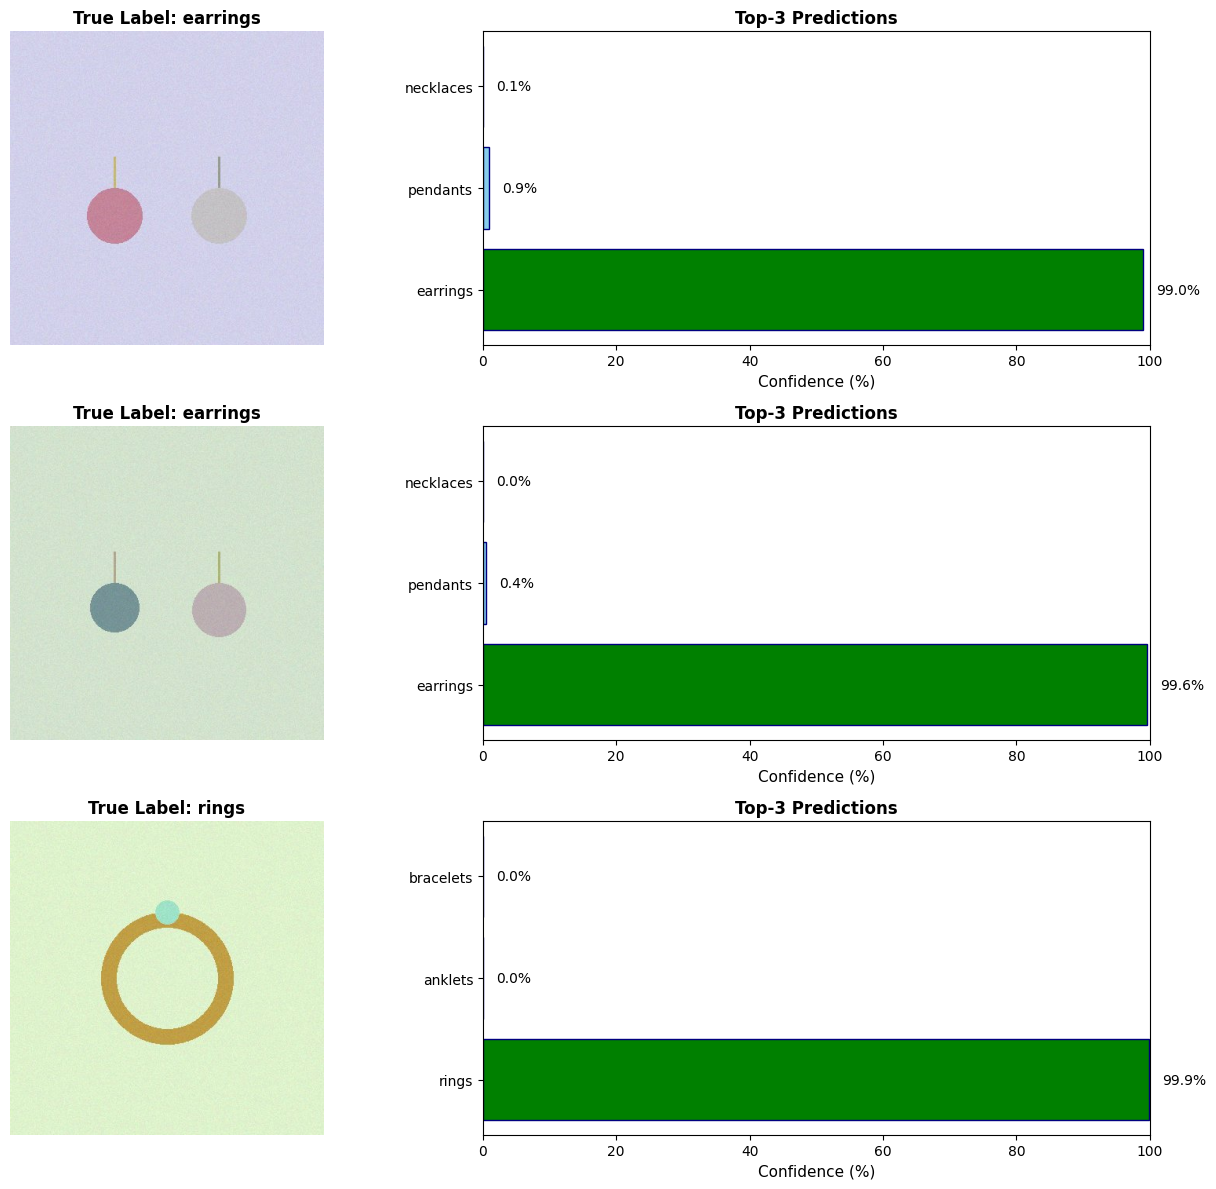

In [14]:
# Show top-3 predictions with confidence scores
num_examples = 3
fig, axes = plt.subplots(num_examples, 2, figsize=(14, num_examples * 4))

for i in range(num_examples):
    random_idx = np.random.randint(0, len(val_dataset))
    img_path = val_paths[random_idx]
    true_label = val_labels[random_idx]
    true_class = idx_to_class[true_label]
    
    img, probs, top_3_idx = predict_image(img_path, model, DEVICE, val_transform)
    
    # Display image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"True Label: {true_class}", fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')
    
    # Display top-3 predictions
    top_3_classes = [idx_to_class[j] for j in top_3_idx]
    top_3_probs = [probs[j] * 100 for j in top_3_idx]
    colors = ['green' if c == true_class else 'skyblue' for c in top_3_classes]
    
    axes[i, 1].barh(top_3_classes, top_3_probs, color=colors, edgecolor='navy')
    axes[i, 1].set_xlabel('Confidence (%)', fontsize=11)
    axes[i, 1].set_title('Top-3 Predictions', fontsize=12, fontweight='bold')
    axes[i, 1].set_xlim(0, 100)
    
    # Add percentage labels
    for j, (cls, prob) in enumerate(zip(top_3_classes, top_3_probs)):
        axes[i, 1].text(prob + 2, j, f'{prob:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 9. Fine-tuning (Optional)

In [15]:
# Unfreeze the base model for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Create new optimizer with lower learning rate
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='min', factor=0.5, patience=2, verbose=True
)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")
print("\nModel ready for fine-tuning!")

Trainable parameters: 2,553,864

Model ready for fine-tuning!


In [16]:
# Fine-tune the model
FINE_TUNE_EPOCHS = 10

print("Starting fine-tuning...\n")
history_fine = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(FINE_TUNE_EPOCHS):
    print(f"Fine-tune Epoch {epoch+1}/{FINE_TUNE_EPOCHS}")
    print("-" * 50)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer_ft, DEVICE)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, DEVICE)
    
    history_fine['train_loss'].append(train_loss)
    history_fine['train_acc'].append(train_acc)
    history_fine['val_loss'].append(val_loss)
    history_fine['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_DIR / 'best_model_finetuned.pth')
        print(f"✓ Saved fine-tuned model with validation accuracy: {val_acc:.2f}%")
    
    scheduler_ft.step(val_loss)
    print()

print("\n✓ Fine-tuning completed!")
print(f"Best validation accuracy after fine-tuning: {best_val_acc:.2f}%")

Starting fine-tuning...

Fine-tune Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it, loss=0.0025, acc=100] 


Train Loss: 0.0141 | Train Acc: 99.69%
Val Loss: 0.0025 | Val Acc: 100.00%

Fine-tune Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it, loss=0.0016, acc=100] 


Train Loss: 0.0047 | Train Acc: 100.00%
Val Loss: 0.0016 | Val Acc: 100.00%

Fine-tune Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it, loss=0.00018, acc=100]


Train Loss: 0.0041 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%

Fine-tune Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it, loss=0.000152, acc=100]


Train Loss: 0.0009 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%

Fine-tune Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it, loss=6.61e-5, acc=100]


Train Loss: 0.0074 | Train Acc: 99.69%
Val Loss: 0.0001 | Val Acc: 100.00%

Fine-tune Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it, loss=4.89e-5, acc=100]


Train Loss: 0.0037 | Train Acc: 99.69%
Val Loss: 0.0000 | Val Acc: 100.00%

Fine-tune Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it, loss=5.59e-5, acc=100]


Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%

Fine-tune Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it, loss=3.93e-5, acc=100]


Train Loss: 0.0010 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Fine-tune Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it, loss=3.08e-5, acc=100]


Train Loss: 0.0012 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Fine-tune Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it, loss=5.15e-5, acc=100]

Train Loss: 0.0007 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%


✓ Fine-tuning completed!
Best validation accuracy after fine-tuning: 100.00%


## 10. Save and Export Model

In [17]:
# Save the final model
final_model_path = MODEL_DIR / 'jewelry_classifier_final.pth'
torch.save(model.state_dict(), final_model_path)
print(f"✓ Model saved to: {final_model_path}")

# Save class names and mappings
import json
metadata = {
    'class_names': class_names,
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class,
    'num_classes': num_classes,
    'img_size': IMG_SIZE
}
metadata_path = MODEL_DIR / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Model metadata saved to: {metadata_path}")

# Model summary
model_size_mb = os.path.getsize(final_model_path) / (1024 * 1024)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n{'='*70}")
print("MODEL SUMMARY")
print(f"{'='*70}")
print(f"Number of classes: {num_classes}")
print(f"Input shape: (3, {IMG_SIZE}, {IMG_SIZE})")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {model_size_mb:.2f} MB")
print(f"Device: {DEVICE}")
print(f"{'='*70}")

✓ Model saved to: /project/models/jewelry_classifier_final.pth
✓ Model metadata saved to: /project/models/model_metadata.json

MODEL SUMMARY
Number of classes: 8
Input shape: (3, 224, 224)
Total parameters: 2,553,864
Trainable parameters: 2,553,864
Model size: 9.98 MB
Device: cpu


## Summary

This notebook demonstrated a complete pipeline for jewelry image classification:

1. **Data Exploration**: Analyzed the dataset structure and class distribution
2. **Data Preparation**: Set up data generators with augmentation
3. **Model Building**: Created a transfer learning model using MobileNetV2
4. **Training**: Trained the model with callbacks for optimization
5. **Evaluation**: Assessed performance with metrics and visualizations
6. **Fine-tuning**: (Optional) Improved model by unfreezing base layers
7. **Deployment**: Saved the final model for production use

**Key Features:**
- Transfer learning with pre-trained MobileNetV2
- Data augmentation to prevent overfitting
- Early stopping and learning rate reduction
- Comprehensive evaluation with confusion matrices
- Top-3 accuracy tracking
- Model checkpoint saving

**Next Steps:**
- Deploy the model as a web service
- Test on real-world jewelry images
- Experiment with other architectures (EfficientNet, ResNet)
- Implement ensemble methods for better accuracy